### 네이버 영화 평점 크롤링

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date=20200402'
page = urlopen(url)

soup = BeautifulSoup(page, 'html.parser')

In [2]:
soup.find_all('div', 'tit5')[:3]

[<div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=19099" title="트루먼 쇼">트루먼 쇼</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=148338" title="동급생">동급생</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=187308" title="조조 래빗">조조 래빗</a>
 </div>]

In [3]:
soup.find_all('div', 'tit5')[0].a

<a href="/movie/bi/mi/basic.nhn?code=19099" title="트루먼 쇼">트루먼 쇼</a>

In [4]:
soup.find_all('div', 'tit5')[0].a.string

'트루먼 쇼'

In [5]:
movie_name = [each.a.string for each in soup.find_all('div', 'tit5')]
movie_name[:3]

['트루먼 쇼', '동급생', '조조 래빗']

In [6]:
soup.find_all('td', 'point')[0].string

'9.33'

In [7]:
movie_point = [each.string for each in soup.find_all('td', 'point')]
movie_point[:3]

['9.33', '9.20', '9.18']

In [8]:
date = pd.date_range('2020.03.01', periods=31, freq='D')
date

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31'],
              dtype='datetime64[ns]', freq='D')

In [9]:
date[0]

Timestamp('2020-03-01 00:00:00', freq='D')

In [10]:
date[0].strftime('%y-%m-%d')

'20-03-01'

In [11]:
date[0].strftime('%y.%m.%d')

'20.03.01'

In [12]:
date[0].strftime('%y%m%d')

'200301'

In [13]:
date[0].strftime('%Y%m%d')

'20200301'

In [14]:
movie_date = []
movie_name = []
movie_point = []

In [15]:
for today in date:
    html = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date={date}'
    response = urlopen(html.format(date=today.strftime('%Y%m%d')))
    soup = BeautifulSoup(response, 'html.parser')
    
    movie_date.extend([today]*len(soup.find_all('td', 'point')))
    movie_name.extend([each.a.string for each in soup.find_all('div', 'tit5')])        
    movie_point.extend([each.string for each in soup.find_all('td', 'point')])    

    time.sleep(0.5)

In [16]:
len(movie_date), len(movie_name),  len(movie_point)

(1522, 1522, 1522)

In [17]:
movie = pd.DataFrame({'date': movie_date, 'name': movie_name, 'point': movie_point})
movie.head(3)

,date,name,point
0,2020-03-01,그린 북,9.60
1,2020-03-01,주전장,9.52
2,2020-03-01,포드 V 페라리,9.51


In [18]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1522 non-null   datetime64[ns]
 1   name    1522 non-null   object        
 2   point   1522 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 35.8+ KB


In [19]:
movie['point'] = movie['point'].astype(float)
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1522 non-null   datetime64[ns]
 1   name    1522 non-null   object        
 2   point   1522 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 35.8+ KB


In [20]:
movie.to_csv('./naver_movie_raw_data.csv', sep=',', encoding='utf-8')

In [21]:
movie = pd.read_csv('./naver_movie_raw_data.csv', index_col=0)
movie.head(3)

,date,name,point
0,2020-03-01,그린 북,9.60
1,2020-03-01,주전장,9.52
2,2020-03-01,포드 V 페라리,9.51


영화 이름으로 인덱스를 잡고 점수의 합산

In [22]:
movie_unique = pd.pivot_table(movie, index=['name'], aggfunc=np.sum)
movie_unique.head(3)

,point
name,
1917,277.48
500일의 썸머,117.74
걸어도 걸어도,129.15


한달 간 네이터 영화 평점 합산 기준 베스트 10

In [23]:
movie_best = movie_unique.sort_values(by='point', ascending=False)
movie_best.tail(10)

,point
name,
신문기자,16.10
존 윅,15.86
일 포스티노,9.15
시티 오브 갓,8.83
브리짓 존스의 베이비,8.80
너의 이름은.,8.76
그을린 사랑,8.65
라붐,7.98
환상의 빛,7.97


DataFrame의 검색 명령 : query

In [24]:
movie.query('name == ["작은 아씨들"]').head(3)

,date,name,point
18,2020-03-01,작은 아씨들,8.88
60,2020-03-02,작은 아씨들,8.88
102,2020-03-03,작은 아씨들,8.88


한 영화에 대한 날짜별 점수

No handles with labels found to put in legend.


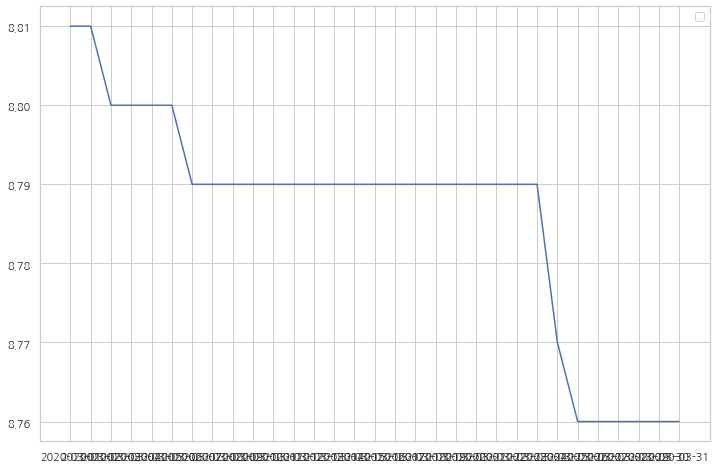

In [25]:
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(movie.query('name == ["벌새"]')['date'],
        movie.query('name == ["벌새"]')['point'])
plt.legend(loc='best')
plt.grid()
plt.grid(); plt.show()

In [26]:
movie_best.head(3)

,point
name,
포드 V 페라리,285.09
조조 래빗,284.81
나이브스 아웃,282.41


In [27]:
movie_best.tail(3)

,point
name,
라붐,7.98
환상의 빛,7.97
닥터 두리틀,6.61


한 달 간의 영화를 모두 정리

In [28]:
movie_pivot = pd.pivot_table(movie, index=['date'], columns=['name'])
movie_pivot.columns = movie_pivot.columns.droplevel([0])
movie_pivot.head()

name,1917,500일의 썸머,걸어도 걸어도,겟 아웃,겨울왕국 2,결혼 이야기,교회오빠,그녀,그랜드 부다페스트 호텔,그렇게 아버지가 된다,...,파리로 가는 길,파이트 클럽,포드 V 페라리,포레스트 검프,피아니스트의 전설,해리 포터와 아즈카반의 죄수,환상의 빛,흑집사 : 북 오브 더 아틀란틱,히트,히트맨
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,8.98,NaN,NaN,NaN,8.7,9.07,NaN,NaN,NaN,NaN,...,7.89,NaN,9.51,NaN,9.25,8.69,NaN,NaN,NaN,6.93
2020-03-02,8.97,NaN,NaN,NaN,8.7,9.08,NaN,NaN,NaN,NaN,...,7.89,NaN,9.51,NaN,9.25,8.69,NaN,NaN,NaN,6.92
2020-03-03,8.98,NaN,NaN,NaN,8.7,9.08,NaN,NaN,NaN,NaN,...,NaN,NaN,9.51,NaN,9.25,8.69,NaN,NaN,NaN,6.91
2020-03-04,8.99,NaN,8.61,NaN,8.7,9.07,NaN,NaN,NaN,8.85,...,NaN,NaN,9.51,NaN,9.25,8.69,7.97,NaN,NaN,6.90
2020-03-05,8.98,NaN,8.61,8.27,8.7,9.07,NaN,8.52,8.38,8.85,...,NaN,NaN,9.51,NaN,9.25,8.69,NaN,NaN,NaN,NaN


엑셀로 저장

In [29]:
movie_pivot.to_excel('./movie_pivot.xlsx')

In [30]:
movie_pivot.columns

Index(['1917', '500일의 썸머', '걸어도 걸어도', '겟 아웃', '겨울왕국 2', '결혼 이야기', '교회오빠', '그녀',
       '그랜드 부다페스트 호텔', '그렇게 아버지가 된다',
       ...
       '파리로 가는 길', '파이트 클럽', '포드 V 페라리', '포레스트 검프', '피아니스트의 전설',
       '해리 포터와 아즈카반의 죄수', '환상의 빛', '흑집사 : 북 오브 더 아틀란틱', '히트', '히트맨'],
      dtype='object', name='name', length=117)

보고싶은 영화 몇개만 추려서 그래프로 확인

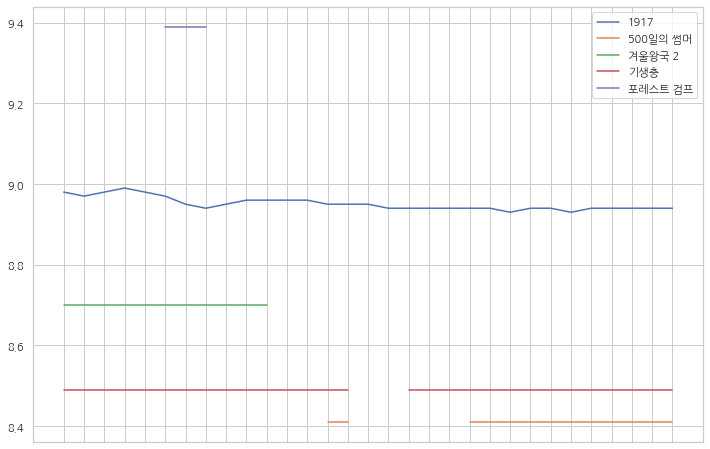

In [31]:
target_col = ['1917', '500일의 썸머', '겨울왕국 2', '기생충', '포레스트 검프']

plt.figure(figsize=(12, 8))
plt.plot(movie_pivot[target_col])
plt.legend(target_col, loc='best')
plt.tick_params(bottom=False, labelbottom=False)
plt.show()